In [125]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical

In [127]:
# --- Step 1: Load the CSV and Display Head ---
# Load the CSV
csv_path = r"C:\Users\marti\Desktop\dom\Data\metadata_f1.csv"
image_dir = r"C:\Users\marti\Desktop\dom\Data"
data = pd.read_csv(csv_path)


In [128]:
# Add '.jpg' extension to the 'isic_id' column
data['isic_id'] = data['isic_id'].astype(str) + '.jpg'

# Filter to include only rows with existing image files
data["image_exists"] = data["isic_id"].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))
data = data[data["image_exists"]]


In [129]:
# Display the head of the dataset
print("CSV Head:")
print(data.head())

CSV Head:
            isic_id diagnosis  age_approx  image_exists
0  ISIC_0024306.jpg     nevus        45.0          True
1  ISIC_0024307.jpg     nevus        50.0          True
2  ISIC_0024308.jpg     nevus        55.0          True
3  ISIC_0024309.jpg     nevus        40.0          True
4  ISIC_0024310.jpg  melanoma        60.0          True


In [130]:
# Résumé des données
print(data.info())

# Statistiques descriptives
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11720 entries, 0 to 11719
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   isic_id       11720 non-null  object 
 1   diagnosis     11720 non-null  object 
 2   age_approx    11337 non-null  float64
 3   image_exists  11720 non-null  bool   
dtypes: bool(1), float64(1), object(2)
memory usage: 377.7+ KB
None
         age_approx
count  11337.000000
mean      52.037135
std       16.704833
min        5.000000
25%       40.000000
50%       50.000000
75%       65.000000
max       85.000000


In [131]:

print(f"Nombre d'ID uniques : {data['isic_id'].nunique()} sur {len(data)}")


Nombre d'ID uniques : 11720 sur 11720


count    11337.000000
mean        52.037135
std         16.704833
min          5.000000
25%         40.000000
50%         50.000000
75%         65.000000
max         85.000000
Name: age_approx, dtype: float64


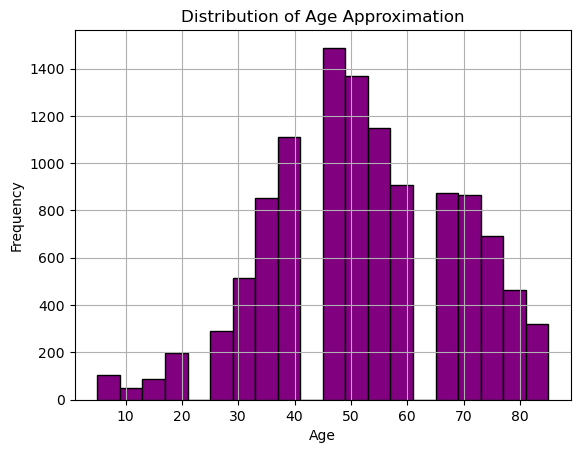

In [132]:
print(data['age_approx'].describe())

# Visualiser la distribution des âges
data['age_approx'].hist(bins=20, color='purple', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age Approximation')
plt.show()


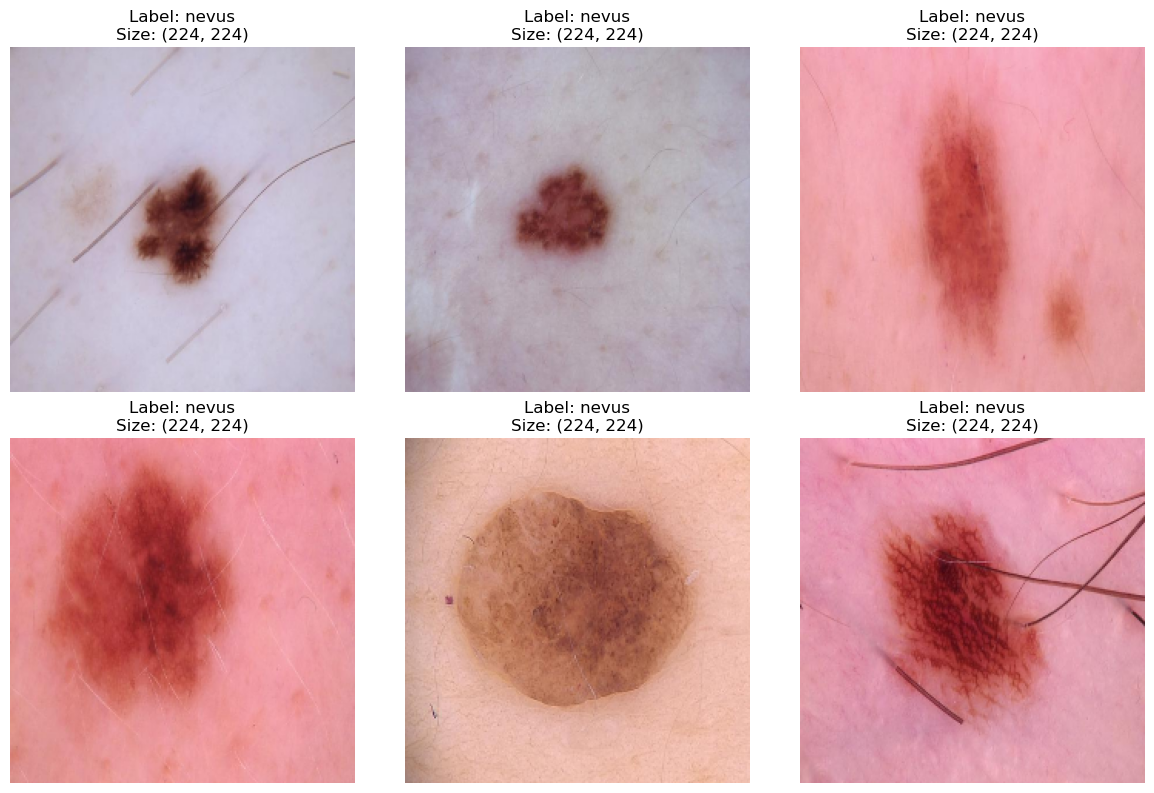

In [133]:
# --- Step 2: Display 6 Images with Labels and Dimensions ---
import matplotlib.image as mpimg
from tensorflow.image import resize

sample_data = data.sample(6)
plt.figure(figsize=(12, 8))
for i, row in enumerate(sample_data.itertuples()):
    image_path = os.path.join(image_dir, f"{row.isic_id}")
    image = mpimg.imread(image_path)
    resized_image = resize(image, (224, 224)).numpy()  # Resize to 224x224
    plt.subplot(2, 3, i + 1)
    plt.imshow(resized_image.astype('uint8'))
    plt.title(f"Label: {row.diagnosis}\nSize: {resized_image.shape[:2]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [135]:
# --- Step 3: Count Images per Label ---
label_counts = data['diagnosis'].value_counts()
print("\nNumber of images per label:")
print(label_counts)


Number of images per label:
nevus                         7737
pigmented benign keratosis    1338
melanoma                      1305
basal cell carcinoma           622
squamous cell carcinoma        229
vascular lesion                180
dermatofibroma                 160
actinic keratosis              149
Name: diagnosis, dtype: int64


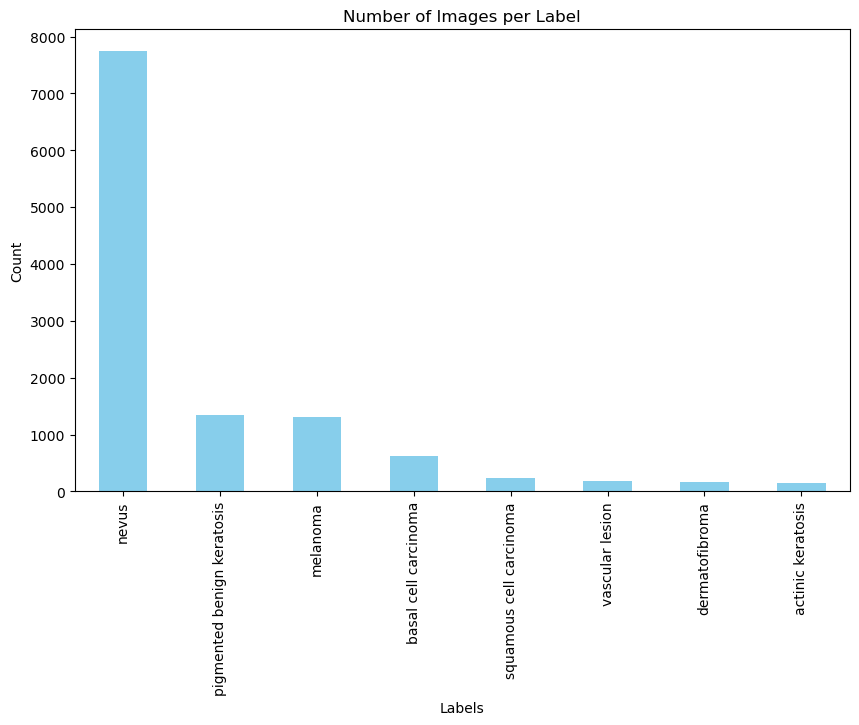

In [136]:
# Plot the counts
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Images per Label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [137]:
# --- Step 4: Split Data into Train, Validation, and Test ---
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['diagnosis'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['diagnosis'], random_state=42)


In [138]:
print("\nDataset split:")
print(f"Train: {len(train_data)} images")
print(f"Validation: {len(val_data)} images")
print(f"Test: {len(test_data)} images")



Dataset split:
Train: 7500 images
Validation: 1876 images
Test: 2344 images


In [139]:
# --- Step 5: Data Augmentation ---
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

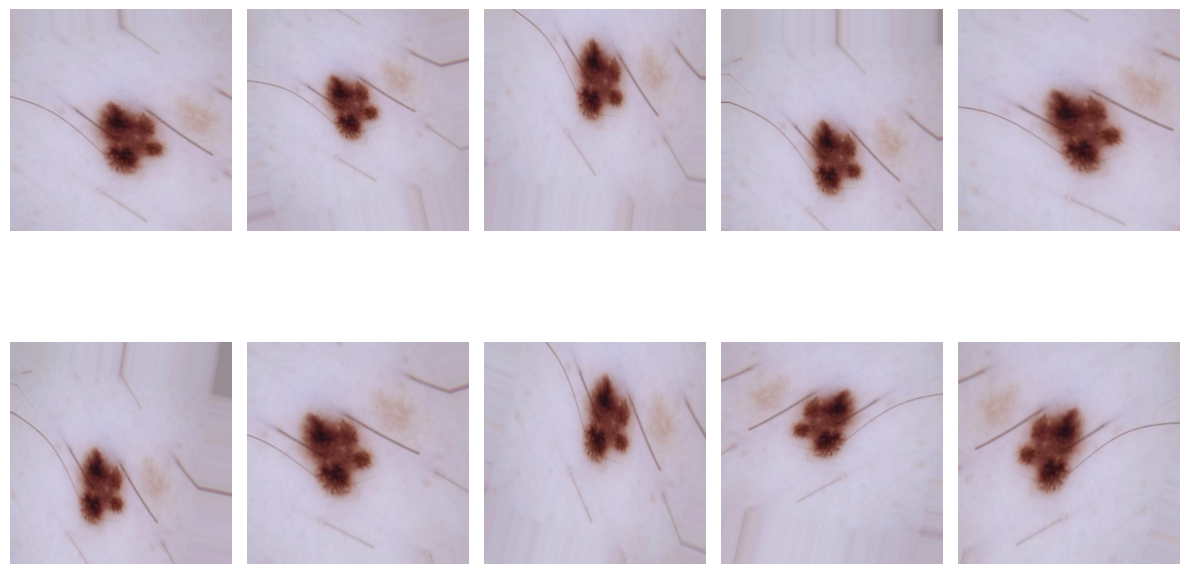

In [140]:
# Load and augment a single image for demonstration
sample_image_path = os.path.join(image_dir, f"{sample_data.iloc[0]['isic_id']}")
sample_image = mpimg.imread(sample_image_path)
sample_image_resized = resize(sample_image, (224, 224)).numpy()  # Resize to 224x224
sample_image_resized = np.expand_dims(sample_image_resized, axis=0)

augmented_images = data_gen.flow(sample_image_resized, batch_size=1)

plt.figure(figsize=(12, 8))
for i in range(10):
    batch = augmented_images.next()
    plt.subplot(2, 5, i + 1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
plt.tight_layout()
plt.show()


In [141]:
# --- Step 6: Image Generators for Training ---
def preprocess_metadata(df):
    # Fill missing values and encode categorical data
    df['age_approx'] = df['age_approx'].fillna(df['age_approx'].median())
    ##df['sex'] = df['sex'].fillna('unknown')
    ##df['sex'] = df['sex'].map({'male': 0, 'female': 1, 'unknown': 2})
    ##df['anatom_site_general'] = df['anatom_site_general'].fillna('unknown')
    ##df = pd.get_dummies(df, columns=['anatom_site_general'], drop_first=True)
    return df



In [142]:
import kerastuner as kt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# --- Step 6: Image Generators for Training ---
train_data = preprocess_metadata(train_data)
val_data = preprocess_metadata(val_data)
test_data = preprocess_metadata(test_data)

train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_dataframe(
    train_data, directory=image_dir, x_col='isic_id', y_col='diagnosis',
    target_size=(224, 224), batch_size=32, class_mode='categorical')

val_generator = val_gen.flow_from_dataframe(
    val_data, directory=image_dir, x_col='isic_id', y_col='diagnosis',
    target_size=(224, 224), batch_size=32, class_mode='categorical')

test_generator = test_gen.flow_from_dataframe(
    test_data, directory=image_dir, x_col='isic_id', y_col='diagnosis',
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False) 

C:\Users\marti\AppData\Local\Temp\ipykernel_41524\2714389411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_approx'] = df['age_approx'].fillna(df['age_approx'].median())


Found 7500 validated image filenames belonging to 8 classes.
Found 1876 validated image filenames belonging to 8 classes.
Found 2344 validated image filenames belonging to 8 classes.


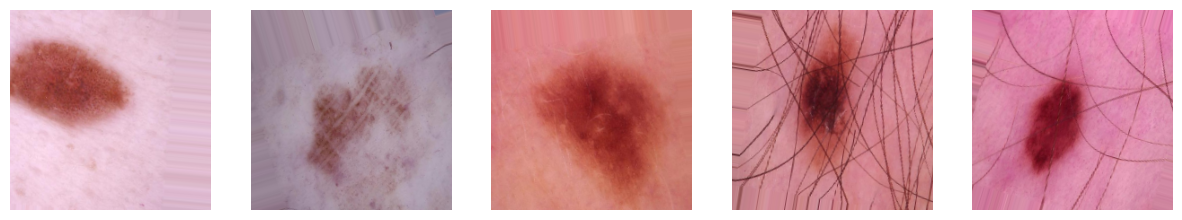

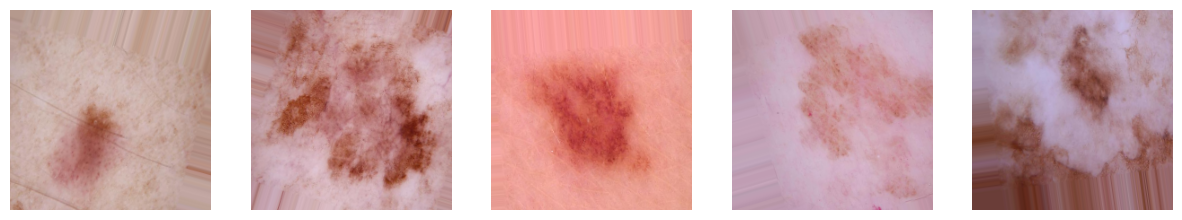

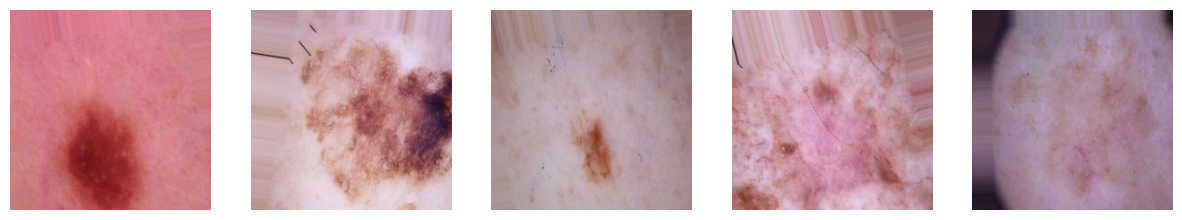

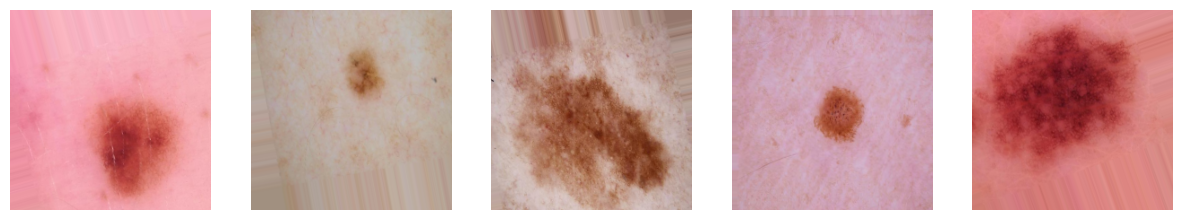

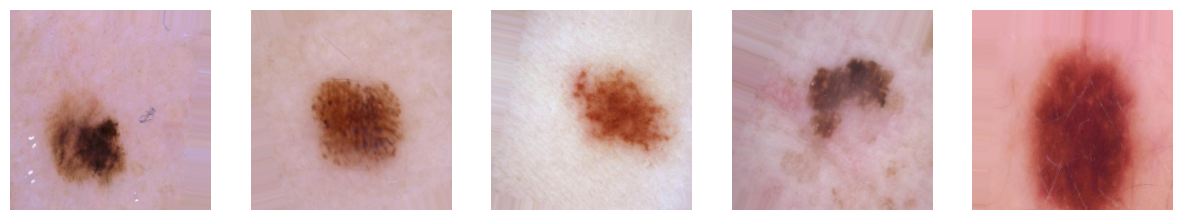

In [143]:
# --- Display Augmented Images ---
def display_augmented_images(generator, num_images=5):
    for i in range(num_images):
        image_batch, _ = next(generator)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for j in range(num_images):
            axes[j].imshow(image_batch[j])
            axes[j].axis('off')
        plt.show()

display_augmented_images(train_generator, num_images=5)

In [144]:
# --- Step 7: Build the Model ---
# Base model (ResNet50)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
for layer in base_model.layers:
    layer.trainable = False

In [145]:
# Metadata input
metadata_input = Input(shape=(train_data.shape[1] - 2,))  # Adjust for metadata columns (exclude 'isic_id' and 'diagnosis')
metadata_dense = Dense(32, activation='relu')(metadata_input)


In [146]:
# Image input
image_input = base_model.input
image_output = base_model.output

In [147]:
# Combine both outputs
combined = concatenate([image_output, metadata_dense])

# Dense layers for final prediction
x = Dense(128, activation='relu')(combined)
x = Dropout(0.3)(x)
output = Dense(len(data['diagnosis'].unique()), activation='softmax')(x)

# Model compilation
model = Model(inputs=[image_input, metadata_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [149]:
# --- Step 8: Train the Model ---
def combined_generator(image_gen, metadata_df, batch_size):
    while True:
        image_batch, labels = next(image_gen)
        indices = image_gen.index_array
        metadata_batch = metadata_df.iloc[indices].drop(columns=['isic_id', 'diagnosis']).values
        yield [image_batch, metadata_batch], labels

train_combined_gen = combined_generator(train_generator, train_data, batch_size=32)
val_combined_gen = combined_generator(val_generator, val_data, batch_size=32)

history = model.fit(
    train_combined_gen,
    steps_per_epoch=len(train_generator),
    validation_data=val_combined_gen,
    validation_steps=len(val_generator),
    epochs=1
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
# --- Save the Model ---
model_save_path = r"C:\Users\marti\Desktop\dom\Data\melanoma_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

In [ ]:
# --- Plot Metrics ---
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history)


In [ ]:
# --- Test the Model ---
def test_model(test_gen, model):
    predictions = model.predict(test_gen, steps=len(test_gen))
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

test_model(test_generator, model)

In [121]:
# --- Step 6: Define a Combined Generator ---
def combined_generator(image_gen, metadata_df, batch_size):
    while True:
        # Get a batch of images and labels
        image_batch, labels = next(image_gen)
        
        # Get the indices for this batch
        indices = image_gen.index_array  # This should be provided by the generator (if not, you can manually track them)
        
        # Extract the corresponding metadata for the batch
        metadata_batch = metadata_df.iloc[indices].drop(columns=['isic_id', 'diagnosis']).values
        
        # Yield the combined batch (images + metadata) and the labels
        yield [image_batch, metadata_batch], labels


In [122]:
# Create combined generators for train, validation, and test sets
train_combined_gen = combined_generator(train_generator, train_data, batch_size=32)
val_combined_gen = combined_generator(val_generator, val_data, batch_size=32)
test_combined_gen = combined_generator(test_generator, test_data, batch_size=32)



In [123]:
# --- Step 7: Build the Model ---
def build_model(hp):
    # Base model (ResNet50)
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
    for layer in base_model.layers:
        layer.trainable = False

    # Metadata input
    metadata_input = Input(shape=(train_data.shape[1] - 2,))  # Adjust for metadata columns (exclude 'isic_id' and 'diagnosis')
    metadata_dense = Dense(32, activation='relu')(metadata_input)

    # Image input
    image_input = base_model.input
    image_output = base_model.output

    # Combine both outputs
    combined = concatenate([image_output, metadata_dense])

    # Dense layers for final prediction
    x = Dense(hp.Int('units', min_value=64, max_value=512, step=64), activation='relu')(combined)
    x = Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)
    output = Dense(len(label_counts), activation='softmax')(x)

    # Model compilation
    model = Model(inputs=[image_input, metadata_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [124]:
# Hyperparameter tuning
print("Starting hyperparameter tuning...")

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_logs',
    project_name='skin_cancer_classification'
)

# Tuning the model with combined generators
tuner.search(
    train_combined_gen,
    validation_data=val_combined_gen,
    steps_per_epoch=len(train_data) // 32,  # Total samples // batch_size
    validation_steps=len(val_data) // 32,   # Total samples // batch_size
    epochs=10
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: Units={best_hps.get('units')}, Dropout={best_hps.get('dropout')}, Learning Rate={best_hps.get('learning_rate')}")



Starting hyperparameter tuning...
Reloading Tuner from tuner_logs\skin_cancer_classification\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |256               |units
0.2               |0.2               |dropout
0.001             |0.0001            |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



Traceback (most recent call last):
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\marti\anaconda3\envs\mat\lib\site-packages\tensorflow\python\framework\constant_op.py", line 102, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).


In [72]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

NameError: name 'best_hps' is not defined

In [36]:
# --- Step 8: Train the Model ---
history = model.fit(
    train_combined_gen,
    steps_per_epoch=len(train_generator),
    validation_data=val_combined_gen,
    validation_steps=len(val_generator),
    epochs=10,
    callbacks=[checkpoint]
)


NameError: name 'model' is not defined

In [ ]:
# --- Step 8 (suite): Plot Training History ---
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# --- Step 9: Evaluate the Model ---
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')


In [ ]:
# Evaluate on test data
test_loss, test_accuracy = best_model.evaluate(
    [test_generator, test_data.drop(columns=['isic_id', 'diagnosis'])], verbose=1)

print("\nTest Accuracy: {:.2f}%".format(test_accuracy * 100))

In [ ]:
# Generate classification report and confusion matrix
y_pred = np.argmax(best_model.predict(
    [test_generator, test_data.drop(columns=['isic_id', 'diagnosis'])]), axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# --- Step 10: Save the Model ---
final_model_path = "C:\\Users\\marti\\Desktop\\dom\\best_skin_cancer_model.h5"
best_model.save(final_model_path)
print(f"Model saved to {final_model_path}")

In [ ]:
# --- Step 11: Test the Model ---
# Test with a random image from the test dataset
random_test_image = test_data.sample(1).iloc[0]
random_test_image_path = os.path.join(image_dir, f"{random_test_image['isic_id']}.jpg")


In [ ]:
# Load and preprocess the image
test_image = mpimg.imread(random_test_image_path)
test_image_resized = resize(test_image, (224, 224)).numpy()
test_image_resized = np.expand_dims(test_image_resized, axis=0) / 255.0

In [ ]:
# Predict
pred = best_model.predict([test_image_resized, random_test_image.drop(['isic_id', 'diagnosis']).to_numpy().reshape(1, -1)])
predicted_label = np.argmax(pred)

print(f"\nPredicted Label: {list(test_generator.class_indices.keys())[predicted_label]}")
print(f"True Label: {random_test_image['diagnosis']}")


In [ ]:
# Display the image
plt.imshow(test_image.astype('uint8'))
plt.title(f"Predicted: {list(test_generator.class_indices.keys())[predicted_label]}\nTrue: {random_test_image['diagnosis']}")
plt.axis('off')
plt.show()

In [ ]:
import cv2
from tensorflow.keras.models import Model

# --- Step 8 (suite): Visualize Important Regions with Grad-CAM ---
def grad_cam(model, img_array, layer_name):
    """
    Generate Grad-CAM for a given model, image, and convolutional layer.
    """
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)

    # Compute guided gradients
    cast_conv_outputs = tf.cast(conv_outputs > 0, "float32")
    cast_grads = tf.cast(grads > 0, "float32")
    guided_grads = cast_conv_outputs * cast_grads * grads

    # Average gradients spatially
    weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))

    # Compute Grad-CAM as a weighted combination of the output feature maps
    cam = np.ones(conv_outputs[0].shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[0, :, :, i]

    # Normalize and resize Grad-CAM
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    return cam

# Test Grad-CAM on a random image
layer_name = 'conv5_block3_out'  # Choose the last convolutional layer in ResNet50
random_test_image_path = os.path.join(image_dir, f"{test_data.sample(1).iloc[0]['isic_id']}")

# Load and preprocess the image
test_image = mpimg.imread(random_test_image_path)
test_image_resized = resize(test_image, (224, 224)).numpy()
test_image_resized = np.expand_dims(test_image_resized, axis=0) / 255.0

# Get Grad-CAM
cam = grad_cam(model, test_image_resized, layer_name)

# Overlay Grad-CAM on the image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = 0.5 * test_image_resized[0] + 0.5 * heatmap / 255.0




In [ ]:
# Display the image and Grad-CAM overlay
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_image.astype('uint8'))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()